## モデル構築

In [12]:
#データの収集

%matplotlib inline
import numpy as np
import torch

import matplotlib.pyplot as plt

In [13]:
#t_cは摂氏
#t_uは単位が知りたい値
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

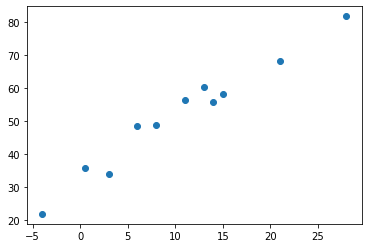

In [14]:
plt.scatter(t_c, t_u)

In [15]:
#データを収集したら、可視化、線形モデルをためす。
#線形モデル　t_c = w * t_u + b
#予測値と測定値の誤差が小さくなるようにモデルのパラメータ（ｗ：重みとｂ：バイアス）を推定する
#誤差の測定方法に損失関数を用いる
#この損失関数が最小になるようなw,bを見つけることを目標とする

## パラメータの推定と損失関数

In [16]:
#モデル作成
def model (t_u, w, b):
    return w* t_u + b

In [17]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [18]:
#パラメータの初期化
w = torch.ones(())
b = torch.zeros(())

In [19]:
w

tensor(1.)

In [20]:
t_p = model(t_u ,w ,b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

In [21]:
#この段階で損失
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8848)

# ブロードキャスティング

In [22]:
#あるテンソルの１つが、他のテンソルよりも大きい次元の場合に他のテンソル全体にあるテンソルの次元に沿った
#計算がされる
import torch
x = torch.ones(())
y = torch.ones(3,1)
z = torch.ones(1,3)
a = torch.ones(2,1,1)
print(f"shape: x:{x.shape} y:{y.shape}")
print(f"z:{z.shape}, a:{a.shape}")
print("x * y:", (x*y).shape)
print("y * z:", (y*z).shape)
print("x * z * a:", (y*z*a).shape)

shape: x:torch.Size([]) y:torch.Size([3, 1])
z:torch.Size([1, 3]), a:torch.Size([2, 1, 1])
x * y: torch.Size([3, 1])
y * z: torch.Size([3, 3])
x * z * a: torch.Size([2, 3, 3])


In [23]:
z,a

(tensor([[1., 1., 1.]]),
 tensor([[[1.]],
 
         [[1.]]]))

In [24]:
#損失を小さくするためには

# 勾配降下法

In [25]:
#各パラメータに対する損失の変化率を計算し、損失が減少する方向に
#各パラメータを補正する

In [26]:
delta = 0.1

#wの変化が損失につながる
loss_rate_of_change_w = \
(loss_fn(model(t_u, w + delta, b),t_c)-
 loss_fn(model(t_u, w - delta, b), t_c)) /(2.0 * delta)

In [27]:
loss_rate_of_change_w 
#この損失の変化量が負の場合は損失を最小化するためにwを増加させる必要がある
#変化量が正の場合はwを減少させる必要がある

#どのくらい変化させた方がいいか
#損失の変化量に比例した変更をwに適用したらよいのではないか
#変化量を調整する係数を学習率と呼ぶ

tensor(4517.2974)

In [28]:
learning_rate = 1e-2
w = w - learning_rate * loss_rate_of_change_w

loss_rate_of_change_b = \
(loss_fn(model(t_u, w, b + delta),t_c)-
 loss_fn(model(t_u, w, b - delta),t_c))/(2.0 * delta)

In [29]:
b = b - learning_rate * loss_rate_of_change_b
b

tensor(46.)

パラメータが複数あるモデルでは各パラメータの損失の個々の導関数を計算する
この計算結果を導関数のベクトル、すなわち勾配と呼ぶ

導関数の計算
損失の導関数を計算するために、連鎖律をつかう

(入力）モデルの出力に関する導関数を、パラメータに関するモデルの導関数と掛け算してもとめる

d loss_fn / dw = (d loss_fn / d t_p) * (d t_p / dw)

In [30]:
#損失関数を再び定義
def loss_fn(t_p, t_c):
    squred_differs= (t_p -t_c)**2
    return squred_differs.mean()

In [31]:
loss_fn(t_p, t_c)

tensor(1763.8848)

In [32]:
#モデルは線形 dx*2 /dx = 2x
#損失の導関数は
def dloss_fn(t_p, t_c):
    dsq_diffs = 2*(t_p - t_c) / t_p.size(0)#除算は平均化のため
    return dsq_diffs

In [33]:
dloss_fn(t_p, t_c), t_p.shape

(tensor([6.4000, 7.6182, 7.8545, 9.8000, 8.2364, 7.4364, 5.6182, 4.6909, 7.7091,
         8.6182, 8.6182]),
 torch.Size([11]))

In [34]:
#model　は　w*t_u + b 

#このmodelの導関数は
def dmodel_dw(t_u, w, b):
    return t_u

def dmodel_db(t_u, w, b):
    return 1.0

In [35]:
#勾配の関数
#損失の導関数に導関数を掛ける（連鎖律）
def  grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)#損失の導関数
    dloss_dw  = dloss_dtp * dmodel_dw(t_u, w, b)#損失の導関数＊weightの導関数　ー＞　パラメータに対する損失の導関数
    dloss_db  = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])
#各パラメータの導関数を求める
#この導関数の集まり（ベクトル）を勾配と呼ぶ
#この出力（パラメータの勾配）を(学習率をかけてから）各パラメータに加えることでモデルを最適化

In [36]:
#反復して繰り返す必要がある
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs +1):
        w, b = params
        #順伝播
        t_p = model(t_u, w, b)
        loss = loss_fn(t_p, t_c)
        #逆伝播
        grad = grad_fn(t_u, t_c, t_p, w, b)
        
      
        
        #パラメータの更新
        params = params - learning_rate * grad
        
        print('Epoch %d, Loss %f' % ( epoch, float(loss)))
        print(f"grad:{grad}")
        print(f"params:{params}")
        
    return params

In [37]:
training_loop(
    n_epochs = 20,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_u,
    t_c = t_c)

Epoch 1, Loss 1763.884766
grad:tensor([4517.2964,   82.6000])
params:tensor([-44.1730,  -0.8260])
Epoch 2, Loss 5802484.500000
grad:tensor([-261257.4062,   -4598.9702])
params:tensor([2568.4011,   45.1637])
Epoch 3, Loss 19408029696.000000
grad:tensor([15109614.0000,   266155.6875])
params:tensor([-148527.7344,   -2616.3931])
Epoch 4, Loss 64915905708032.000000
grad:tensor([-8.7385e+08, -1.5393e+07])
params:tensor([8589999.0000,  151310.8906])
Epoch 5, Loss 217130525461053440.000000
grad:tensor([5.0539e+10, 8.9023e+08])
params:tensor([-4.9680e+08, -8.7510e+06])
Epoch 6, Loss 726257583152928129024.000000
grad:tensor([-2.9229e+12, -5.1486e+10])
params:tensor([2.8732e+10, 5.0610e+08])
Epoch 7, Loss 2429183416467662896627712.000000
grad:tensor([1.6904e+14, 2.9776e+12])
params:tensor([-1.6617e+12, -2.9270e+10])
Epoch 8, Loss 8125122549611731432050262016.000000
grad:tensor([-9.7764e+15, -1.7221e+14])
params:tensor([9.6102e+13, 1.6928e+12])
Epoch 9, Loss 27176882120842590626938030653440.00000

tensor([1.3457e+35, 2.3704e+33])


損失が無限大になった

この訓練では変数が大きすぎる更新を受け取ったことを示す兆候である
各更新がオーバーシュートして、次の更新がさらに過大評価され、最適化が収束する代わりに発散する
本来はどんどん小さくしていきたい

learning_rateは学習がうまくいかなかったときに変更することが多いパラメータの一つ

In [38]:
training_loop(
    n_epochs = 20,
    learning_rate = 1e-4,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_u,
    t_c = t_c)

Epoch 1, Loss 1763.884766
grad:tensor([4517.2964,   82.6000])
params:tensor([ 0.5483, -0.0083])
Epoch 2, Loss 323.090515
grad:tensor([1859.5493,   35.7843])
params:tensor([ 0.3623, -0.0118])
Epoch 3, Loss 78.929634
grad:tensor([765.4666,  16.5122])
params:tensor([ 0.2858, -0.0135])
Epoch 4, Loss 37.552845
grad:tensor([315.0790,   8.5787])
params:tensor([ 0.2543, -0.0143])
Epoch 5, Loss 30.540283
grad:tensor([129.6733,   5.3127])
params:tensor([ 0.2413, -0.0149])
Epoch 6, Loss 29.351154
grad:tensor([53.3495,  3.9682])
params:tensor([ 0.2360, -0.0153])
Epoch 7, Loss 29.148884
grad:tensor([21.9304,  3.4148])
params:tensor([ 0.2338, -0.0156])
Epoch 8, Loss 29.113848
grad:tensor([8.9964, 3.1869])
params:tensor([ 0.2329, -0.0159])
Epoch 9, Loss 29.107145
grad:tensor([3.6721, 3.0930])
params:tensor([ 0.2325, -0.0162])
Epoch 10, Loss 29.105247
grad:tensor([1.4803, 3.0544])
params:tensor([ 0.2324, -0.0166])
Epoch 11, Loss 29.104168
grad:tensor([0.5781, 3.0384])
params:tensor([ 0.2323, -0.0169])

tensor([ 0.2323, -0.0196])

## 今度はlearnig_rateが小さく、更新も小さく途中で終わってしまった
adaptiveな変更が良いのではないか

もう一つ問題がある

## 入力の正規化




勾配の大きさが重みと、バイアスで約50倍の差がある
これはこれらのパラメータのスケールが異なるため

片方のスケールに合わせた学習率では片方では大きすぎるか、または小さすぎる可能性がある。

解決には問題の定式化の変更が必要
入力の範囲を―１から１の範囲に収めればよいのではないか

In [39]:
#目的
t_c

tensor([ 0.5000, 14.0000, 15.0000, 28.0000, 11.0000,  8.0000,  3.0000, -4.0000,
         6.0000, 13.0000, 21.0000])

In [40]:
#入力
t_u

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

In [41]:
#入力値の変更
#normalized:n
t_un = 0.1 * t_u

In [42]:
training_loop(
    n_epochs = 20 ,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_un,
    t_c = t_c)

Epoch 1, Loss 80.364342
grad:tensor([-77.6140, -10.6400])
params:tensor([1.7761, 0.1064])
Epoch 2, Loss 37.574913
grad:tensor([-30.8623,  -2.3864])
params:tensor([2.0848, 0.1303])
Epoch 3, Loss 30.871077
grad:tensor([-12.4631,   0.8587])
params:tensor([2.2094, 0.1217])
Epoch 4, Loss 29.756193
grad:tensor([-5.2218,  2.1327])
params:tensor([2.2616, 0.1004])
Epoch 5, Loss 29.507153
grad:tensor([-2.3715,  2.6310])
params:tensor([2.2853, 0.0740])
Epoch 6, Loss 29.392456
grad:tensor([-1.2492,  2.8241])
params:tensor([2.2978, 0.0458])
Epoch 7, Loss 29.298828
grad:tensor([-0.8071,  2.8970])
params:tensor([2.3059, 0.0168])
Epoch 8, Loss 29.208717
grad:tensor([-0.6325,  2.9227])
params:tensor([ 2.3122, -0.0124])
Epoch 9, Loss 29.119415
grad:tensor([-0.5633,  2.9298])
params:tensor([ 2.3178, -0.0417])
Epoch 10, Loss 29.030489
grad:tensor([-0.5355,  2.9295])
params:tensor([ 2.3232, -0.0710])
Epoch 11, Loss 28.941877
grad:tensor([-0.5240,  2.9264])
params:tensor([ 2.3284, -0.1003])
Epoch 12, Loss 2

tensor([ 2.3746, -0.3615])

学習率が1e-2でもパラメータが爆発的に大きくならず、lossも落ち着いている
勾配もどちらの値も大きな差がない

今回は単純に入力値を1/10にして出力値に近づけたが、きちんとした正規化の方が良い働きをする

In [43]:
params = training_loop(
    n_epochs = 5000 ,
    learning_rate = 1e-2,
    params = torch.tensor([1.0, 0.0]),
    t_u = t_un,
    t_c = t_c)

Epoch 1, Loss 80.364342
grad:tensor([-77.6140, -10.6400])
params:tensor([1.7761, 0.1064])
Epoch 2, Loss 37.574913
grad:tensor([-30.8623,  -2.3864])
params:tensor([2.0848, 0.1303])
Epoch 3, Loss 30.871077
grad:tensor([-12.4631,   0.8587])
params:tensor([2.2094, 0.1217])
Epoch 4, Loss 29.756193
grad:tensor([-5.2218,  2.1327])
params:tensor([2.2616, 0.1004])
Epoch 5, Loss 29.507153
grad:tensor([-2.3715,  2.6310])
params:tensor([2.2853, 0.0740])
Epoch 6, Loss 29.392456
grad:tensor([-1.2492,  2.8241])
params:tensor([2.2978, 0.0458])
Epoch 7, Loss 29.298828
grad:tensor([-0.8071,  2.8970])
params:tensor([2.3059, 0.0168])
Epoch 8, Loss 29.208717
grad:tensor([-0.6325,  2.9227])
params:tensor([ 2.3122, -0.0124])
Epoch 9, Loss 29.119415
grad:tensor([-0.5633,  2.9298])
params:tensor([ 2.3178, -0.0417])
Epoch 10, Loss 29.030489
grad:tensor([-0.5355,  2.9295])
params:tensor([ 2.3232, -0.0710])
Epoch 11, Loss 28.941877
grad:tensor([-0.5240,  2.9264])
params:tensor([ 2.3284, -0.1003])
Epoch 12, Loss 2

In [44]:
params

tensor([  5.3671, -17.3012])

5000回ループしてもしっかり損失が減少していっている

In [45]:
t_p = model(t_un, *params)
t_p

tensor([ 1.8593, 12.7008, 13.9352, 26.6552, 12.9155,  8.9439,  0.8932, -5.6009,
         8.6755, 15.1160, 19.4097])

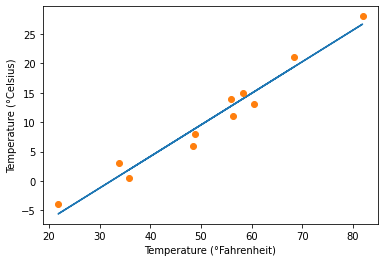

In [46]:
fig = plt.figure()
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(),  t_p.detach().numpy())#予測
plt.plot(t_u.numpy(),  t_c.numpy(), 'o')#答え
#plt.savefig("temp_unknown_plot.png", format="png")  # 保存

微分の連鎖律を通して導関数を後方に伝播させることで、
モデルと損失関数から構成される合成関数の内部パラメータに関する勾配wを計算した

## 勾配の自動計算

pytorchのautogradは導関数の連鎖を自動的に計算する\n
手計算でモデルの導関数を求める必要がない

In [47]:
#再度定義
def model(t_u, w, b):
    return w * t_u + b

def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [48]:
#求めたいパラメータのテンソル変数を初期化

#requires_gradはテンソルのツリーすべてを追跡して微分可能にする
#この＝Trueにしたテンソルを起点にモデルを呼び出し、損失を計算して最後にbackward（逆伝播）を呼び出す
params = torch.tensor([1.0, 0.0], requires_grad=True)

In [49]:
params

tensor([1., 0.], requires_grad=True)

In [50]:
loss = loss_fn(model(t_u, *params), t_c)
loss.backward()

In [51]:
params.grad
#損失の導関数が計算される

tensor([4517.2969,   82.6000])

In [52]:
#paramsの導関数の計算結果は保持されており、backwardを実行すると累積（合計）されてしまう。

In [53]:
#二回目
loss = loss_fn(model(t_u, *params), t_c)
loss.backward()

params.grad

tensor([9034.5938,  165.2000])

In [54]:
#明示的に勾配を０にする必要がある下記が必要

if params.grad is not None:
    params.grad.zero_()

In [55]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:  # <1>
            params.grad.zero_()
        
        t_p = model(t_u, *params) 
        loss = loss_fn(t_p, t_c)
        loss.backward()
        
        with torch.no_grad():  # <2>
            params -= learning_rate * params.grad

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            
    return params

In [56]:
training_loop(
    n_epochs = 5000, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0], requires_grad=True), # <1> 
    t_u = t_un, # <2> 
    t_c = t_c)

Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

様々な最適化関数

In [57]:
import torch
import torch.optim as optim

dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional',
 '_multi_tensor',
 'lr_scheduler',
 'swa_utils']

全て　required_grad=Trueのパラメータのリストを受け取る


オプティマイザのオブジェクトは内部にパラメータを保持し、パラメータのgradにアクセスできる



各オプティマイザクラスはzero_gradとstepのメソッドを公開しており、

zero_gradで構築時に渡しているパラメータのgradを0にする

stepは各パラメータの更新

In [58]:
params = torch.tensor([1.0, 0.0], requires_grad = True)
learning_rate =1e-5
optimizer = optim.SGD([params],lr=learning_rate)

step時にgradを見て、gradの更新、paramsの値に学習率をかけたgradの値を引き算する


In [59]:
t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)

t_p = model(t_un, *params)
loss = loss_fn(t_p, t_c)

optimizer.zero_grad()
#backward時に勾配が累積されるため、直前にzero_grad
loss.backward()

optimizer.step()

params

tensor([1.0008e+00, 1.0640e-04], requires_grad=True)

In [60]:
#手動の最適化をモジュールで
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 500 ==0:
            print('Epoch %d, Loss %f'%(epoch, float(loss)))
    return params

In [61]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)
training_loop(n_epochs=5000,
             optimizer = optimizer,
             params = params,
             t_u = t_un,
             t_c = t_c)

Epoch 500, Loss 7.860120
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

In [62]:
#他のオプティマイザを使用
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr=learning_rate)
training_loop(n_epochs=2000,
             optimizer = optimizer,
             params = params,
             t_u = t_u,
             t_c = t_c)

Epoch 500, Loss 7.612900
Epoch 1000, Loss 3.086700
Epoch 1500, Loss 2.928579
Epoch 2000, Loss 2.927644


tensor([  0.5367, -17.3021], requires_grad=True)

線形変換で解決できる問題だったため、モデルの変更は今回無意味だが、
オプティマイザ以外にもモデル関数の変更も行うことを考慮する

##　検証データの汎化

過学習を防ぐためには過学習が起こるかもしれないことを認識すること

そのためにはデータを検証セットと訓練セットに分け、訓練セットにモデルをfitする
損失は訓練セットと検証セットを一回ずつ評価できる

訓練

訓練データではモデルが訓練データ内の情報を処理できるか確認する。
パラメータが少なければ、ネットワークで近似できる関数の形状は単純になる

訓練データの損失が減少しない場合はモデルがデータに対して単純すぎる可能性がある
他の可能性としては訓練データに出力を説明できるような意味のある情報が含まれていないケースがある

検証

検証データで評価した損失値が、訓練データでの結果とともに減少しない場合は、
モデルは訓練データへの適合性は改善出来ているが、訓練に使用したデータ以外には汎化していないことを意味する

訓練データでの損失と検証データでの損失が乖離している場合は過学習を意味する。

ペナルティ項

十分なデータがある場合にモデルにフィットさせる時は可能な限り定常的であることを確認する。
そのためにペナルティ項を設けてモデルの変化を鈍くする。

他には入力データへノイズを加える、モデルをシンプルなものにするといった方法がある

In [63]:
#データセットの分割

n_samples = t_u.shape[0]
n_samples

11

In [64]:
n_val = int(0.2 * n_samples)
n_val

2

In [65]:
#並び替え
suffled_indices = torch.randperm(n_samples)
suffled_indices

tensor([ 2,  6,  4, 10,  8,  9,  7,  0,  3,  1,  5])

In [66]:
#データ分けのインデックス取得
train_indices = suffled_indices[:-n_val]
val_indices = suffled_indices[-n_val:]
print(train_indices, val_indices)

tensor([ 2,  6,  4, 10,  8,  9,  7,  0,  3]) tensor([1, 5])


In [67]:
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

In [68]:
train_t_un = 0.1* train_t_u
val_t_un = 0.1* val_t_u

In [69]:
val_t_p = model(val_t_u, *params)
val_t_p

tensor([12.7008,  8.9437], grad_fn=<AddBackward0>)

In [70]:
val_t_c

tensor([14.,  8.])

In [71]:
loss_fn(val_t_p, val_t_c)

tensor(1.2893, grad_fn=<MeanBackward0>)

In [72]:
def tarining_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs +1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)
        
        val_t_p = model(val_t_u, *params)
        val_loss = loss_fn(val_t_p, val_t_c)
        
        optimizer.zero_grad()
        train_loss.backward()#trainの時のみbackward
        optimizer.step()
        
        if epoch <= 3 or epoch % 500 ==0:
            print(f"Epoch {epoch}, Train loss{train_loss.item():.4f},"
                  f"Valdation loss{val_loss.item():.4f}")
            
    return params

In [73]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

tarining_loop(n_epochs=3000,
              optimizer = optimizer,
              params = params,
              train_t_u = train_t_un,
              val_t_u = val_t_un,
              train_t_c = train_t_c,
              val_t_c = val_t_c)

Epoch 1, Train loss89.2897,Valdation loss40.2001
Epoch 2, Train loss42.9957,Valdation loss7.5859
Epoch 3, Train loss35.9978,Valdation loss5.1593
Epoch 500, Train loss7.4615,Valdation loss2.4141
Epoch 1000, Train loss3.8338,Valdation loss1.6143
Epoch 1500, Train loss3.3591,Valdation loss1.4178
Epoch 2000, Train loss3.2970,Valdation loss1.3589
Epoch 2500, Train loss3.2889,Valdation loss1.3391
Epoch 3000, Train loss3.2878,Valdation loss1.3322


tensor([  5.3320, -17.1560], requires_grad=True)

In [74]:
# 桁違いではないが検証データより訓練データの損失の方が小さい
# 理想はどちらも同じように下がっていくことだが、検証より訓練の方が大きく下がっていくのは許容範囲

自動微分とテンソルの関係

訓練データではtrain_t_u -> train_t_p -> train_loss の計算グラフが作成されており、
テストデータでも同様に別のグラフが作成されている。

baskward()されたら指定のlossの導関数がoptmaozeに累積される。

間違ってval_lossでもbackward（）したらその導関数も累積され、全てのデータで学習するのと同じになる。

In [75]:
#torch.no_grad

In [76]:
def tarining_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs +1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)
        
        with torch.no_grad():
            val_t_p = model(val_t_u, *params)
            val_loss = loss_fn(val_t_p, val_t_c)
            assert val_loss.requires_grad == False#強制的な確認、異なっていたらエラー
        
        optimizer.zero_grad()
        train_loss.backward()#trainの時のみbackward
        optimizer.step()
        
        if epoch <= 3 or epoch % 500 ==0:
            print(f"Epoch {epoch}, Train loss{train_loss.item():.4f},"
                  f"Valdation loss{val_loss.item():.4f}")
            
    return params

In [77]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

tarining_loop(n_epochs=3000,
              optimizer = optimizer,
              params = params,
              train_t_u = train_t_un,
              val_t_u = val_t_un,
              train_t_c = train_t_c,
              val_t_c = val_t_c)

Epoch 1, Train loss89.2897,Valdation loss40.2001
Epoch 2, Train loss42.9957,Valdation loss7.5859
Epoch 3, Train loss35.9978,Valdation loss5.1593
Epoch 500, Train loss7.4615,Valdation loss2.4141
Epoch 1000, Train loss3.8338,Valdation loss1.6143
Epoch 1500, Train loss3.3591,Valdation loss1.4178
Epoch 2000, Train loss3.2970,Valdation loss1.3589
Epoch 2500, Train loss3.2889,Valdation loss1.3391
Epoch 3000, Train loss3.2878,Valdation loss1.3322


tensor([  5.3320, -17.1560], requires_grad=True)

##　演習問題

In [78]:
#モデルと引数の変更
#パラメータが増え損失は軽減できる
def model2(t_u, w1, w2, b):
    return w2 * t_u ** 2 + w1 * t_u +b

In [79]:
def tarining_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs +1):
        train_t_p = model2(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)
        
        with torch.no_grad():
            val_t_p = model2(val_t_u, *params)
            val_loss = loss_fn(val_t_p, val_t_c)
            assert val_loss.requires_grad == False#強制的な確認、異なっていたらエラー
        
        optimizer.zero_grad()
        train_loss.backward()#trainの時のみbackward
        optimizer.step()
        
        if epoch <= 3 or epoch % 500 ==0:
            print(f"Epoch {epoch}, Train loss{train_loss.item():.4f},"
                  f"Valdation loss{val_loss.item():.4f}")
            
    return params

In [80]:
params2 = torch.tensor([1.0, 1.0, 0.0], requires_grad=True)
learning_rate = 1e-4
optimizer = optim.SGD([params2], lr=learning_rate)

tarining_loop(n_epochs=3000,
              optimizer = optimizer,
              params = params2,
              train_t_u = train_t_un,
              val_t_u = val_t_un,
              train_t_c = train_t_c,
              val_t_c = val_t_c)

Epoch 1, Train loss719.9368,Valdation loss477.1533
Epoch 2, Train loss410.7798,Valdation loss273.7194
Epoch 3, Train loss237.3644,Valdation loss158.4794
Epoch 500, Train loss12.0079,Valdation loss2.7905
Epoch 1000, Train loss9.3329,Valdation loss2.4306
Epoch 1500, Train loss7.4799,Valdation loss2.3789
Epoch 2000, Train loss6.1959,Valdation loss2.5070
Epoch 2500, Train loss5.3059,Valdation loss2.7318
Epoch 3000, Train loss4.6885,Valdation loss3.0003


tensor([-0.6785,  0.5154, -0.7475], requires_grad=True)

In [81]:
t_p1 = model(t_un, *params)
t_p2 = model2(t_un, *params2)

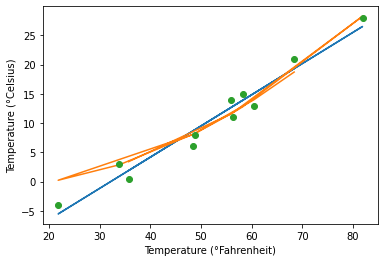

In [82]:
fig = plt.figure()
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(),  t_p1.detach().numpy())

plt.plot(t_u.numpy(),  t_p2.detach().numpy())
plt.plot(t_u.numpy(),  t_c.numpy(), 'o')#答え

In [83]:
#良い結果になってしまったが、本来真のモデルではないため過学習になりval loss が増大する